In [1]:
import random
import matplotlib.pyplot as plt
import pandas as pd
from ete3 import Tree
from io import StringIO
from Bio import Phylo, Entrez, AlignIO, SeqIO, Align
import scienceplots
import networkx as nx

In [2]:
genes = []

In [3]:
fitness_df = pd.read_csv("../fitness.csv")

In [4]:
data = ""
with open("../Refs/mp.txt", 'r') as file:
    data = file.read()

terms = data.strip().split("[Term]\n")
arr = []
for term in terms:
    if term:
        lines = term.strip().split("\n")
        term_data = {
            "id": "",
        }
    
        for line in lines:
            if line:
                if ":" in line:
                    key, value = line.split(":", 1)
                    key = key.strip().lower()
                    if key == "id":
                        term_data["id"] = value.strip()
            arr.append(term_data)
    df = pd.DataFrame(arr)

In [5]:
data = ""
with open("../Refs/mptarget.txt", 'r') as file:
    data = file.read()

terms = data.strip().split("[Term]\n")
arr = []
for term in terms:
    if term:
        lines = term.strip().split("\n")
        term_data = {
            "id": "",
        }
    
        for line in lines:
            if line:
                if ":" in line:
                    key, value = line.split(":", 1)
                    key = key.strip().lower()
                    if key == "id":
                        term_data["id"] = value.strip()
            arr.append(term_data)
    df2 = pd.DataFrame(arr)

In [6]:
df = df["id"].unique()

In [7]:
df2 = df2["id"].unique()

In [8]:
fitness_scores = []
for i in range(len(fitness_df)):
    for j in range(len(df)):
        if fitness_df["id"][i] == df[j]:
            fitness_scores.append(fitness_df["fitness_score"][i])

In [9]:
fitness_scores2 = []
for i in range(len(fitness_df)):
    for j in range(len(df2)):
        if fitness_df["id"][i] == df2[j]:
            fitness_scores2.append(fitness_df["fitness_score"][i])

In [10]:
df = pd.DataFrame([{"id": id, "fitness": fitness} for id, fitness in zip(df, fitness_scores)])

In [11]:
df2 = pd.DataFrame([{"id": id, "fitness": fitness} for id, fitness in zip(df2, fitness_scores)])

In [12]:
df

,id,fitness
0,MP:0004738,-6
1,MP:0002638,0
2,MP:0000376,0
3,MP:0003449,-6
4,MP:0000410,-6
5,MP:0000923,-1
6,MP:0001713,-6
7,MP:0002276,-2
8,MP:0001191,1
9,MP:0000130,-6


In [13]:
df2

,id,fitness
0,MP:0000088,-6
1,MP:0000091,0
2,MP:0000097,0


In [14]:
df2

,id,fitness
0,MP:0000088,-6
1,MP:0000091,0
2,MP:0000097,0


In [15]:
df = pd.DataFrame([{"id": i, "fitness": fit} for i, fit in zip([*df["id"].tolist(), *df2["id"].tolist()], [*df["fitness"].tolist(), *df2["fitness"].tolist()])])

In [16]:
df

,id,fitness
0,MP:0004738,-6
1,MP:0002638,0
2,MP:0000376,0
3,MP:0003449,-6
4,MP:0000410,-6
5,MP:0000923,-1
6,MP:0001713,-6
7,MP:0002276,-2
8,MP:0001191,1
9,MP:0000130,-6


In [17]:
bad_gene = df.loc[df["fitness"] == -6]["id"]

In [18]:
bad_gene = bad_gene.tolist()

In [19]:
good_gene = df2.loc[df2["fitness"] == 0]["id"]

In [20]:
good_gene = good_gene.tolist()

In [21]:
class Rat:
    def __init__(self, id, mps, fitness):
        self.id = id
        self.mps = mps
        self.fitness = fitness
    
    def show(self):
        return f"(fitness:{self.fitness})"
    
    def select_random_gene(self):
        return [random.choice(self.mps) for _ in range(5)]
    
    def edit_gene(self, genes):
        for i in range(len(self.mps)):
            if self.mps[i] in bad_gene:
                self.mps[i] = random.choice(genes)
                self.fitness += 6
    
    def get_fitness(self):
        return self.fitness             
    
    def __repr__(self):
        return f"gen{self.id}fitnessscore{self.fitness}"
    
    def __str__(self):
        return f"{self.id}f{self.fitness}"

In [22]:
df["id"][0]

'MP:0004738'

In [23]:
def breed(rat1, rat2, gene_edit: bool = False):
    genes = [*rat1.select_random_gene(), *rat2.select_random_gene()]
    fit = 0
    identity = str(int(rat1.id) + 1)
    for i in genes:
        for j in range(len(df)):
            if df["id"][j] == i:
                fit += df.iloc[j, 1]
    r = Rat(identity, genes, fit)
    if gene_edit:
        r.edit_gene(["MP:0000088", "MP:0000097"])
    return r

In [24]:
rats = [Rat(f"1", df["id"].tolist(), sum(list(map(lambda f: f, df["fitness"])))), Rat(f"1", df["id"].tolist(), sum(list(map(lambda f: f, df["fitness"]))))]

gen 1, average fitness score: -1.3333333333333333
gen 2, average fitness score: -0.6666666666666666


gen 3, average fitness score: -0.3333333333333333
gen 4, average fitness score: -0.6666666666666666
gen 5, average fitness score: -0.3333333333333333
gen 6, average fitness score: -0.3333333333333333
gen 7, average fitness score: 0.0
gen 8, average fitness score: 0.0
gen 9, average fitness score: 0.0


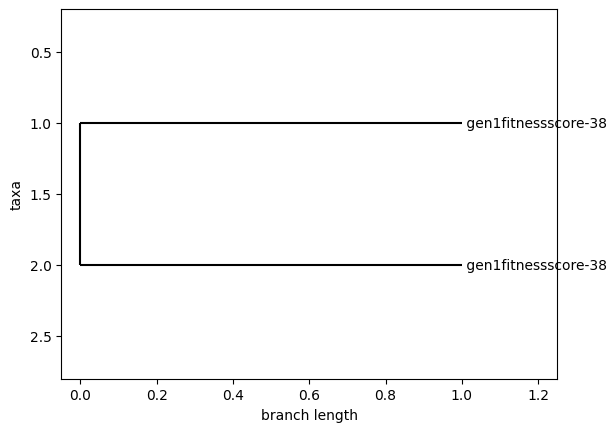

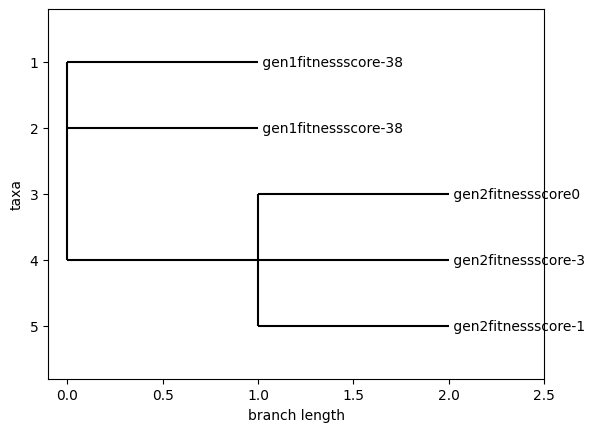

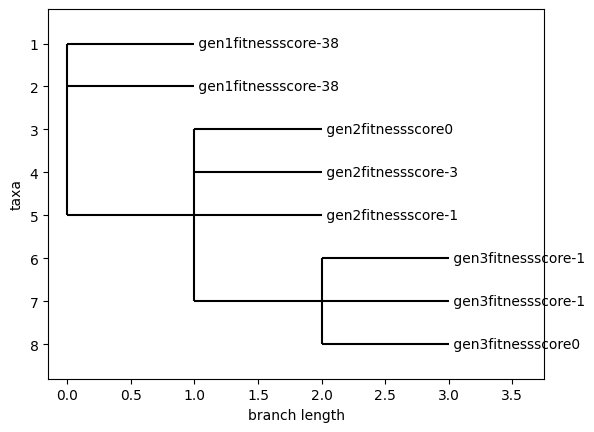

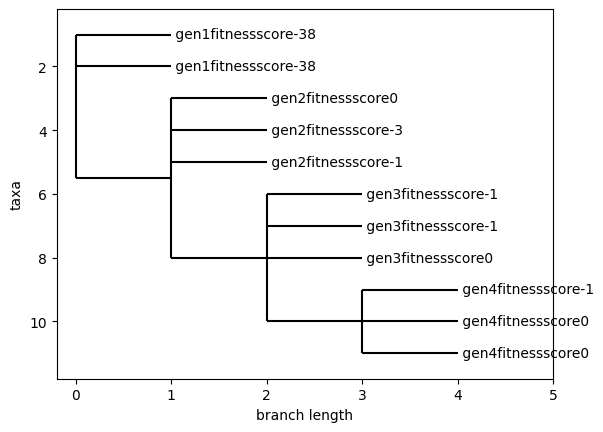

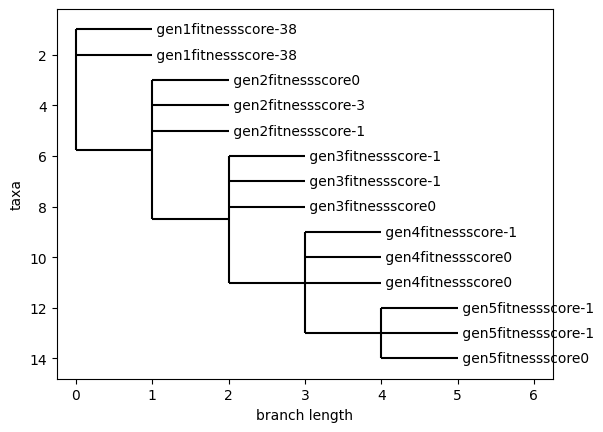

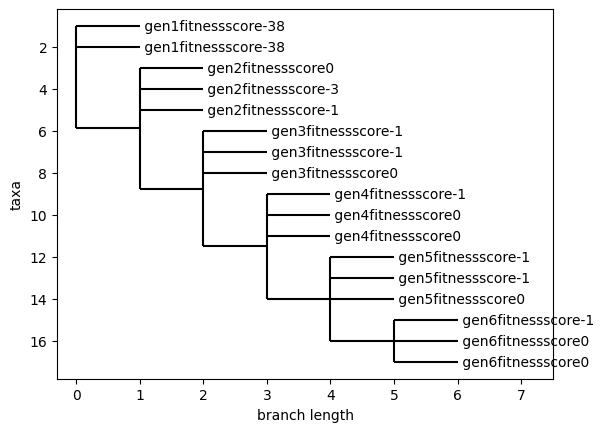

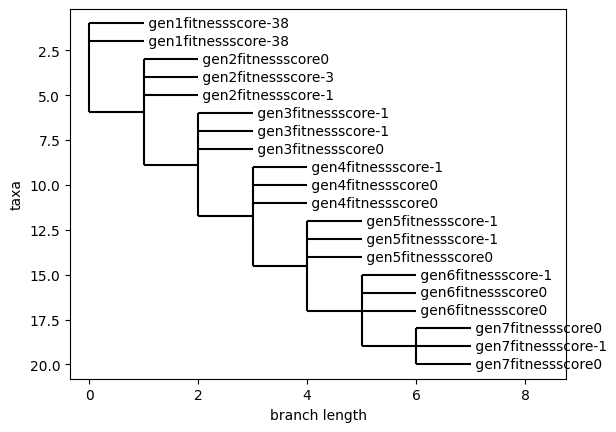

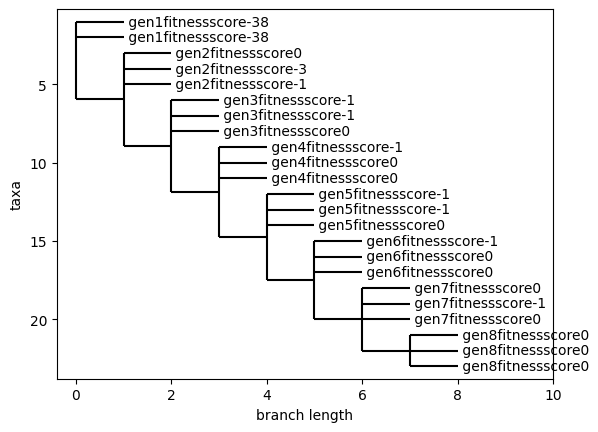

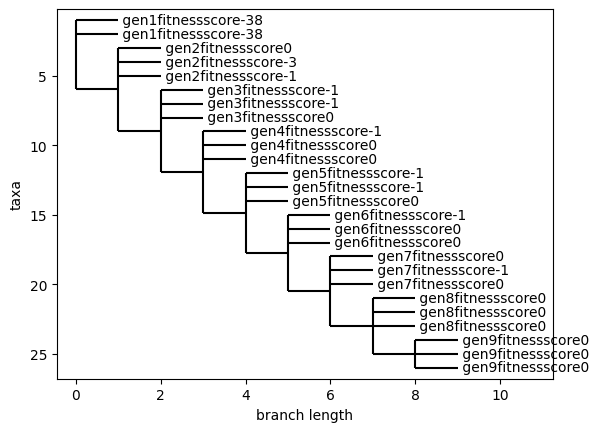

: 

In [25]:
def generate_newick_tree():
    tree = []
    prev_gen = [random.choice(rats), random.choice(rats)]
    tree.append(prev_gen)
    
    for i in range(1, 10):
        newick_tree = str(tree).replace("[", "(").replace("]", ")")[1: -1] + ";"
        phylo_tree = Phylo.read(StringIO(newick_tree), "newick")
        Phylo.draw(phylo_tree, do_show=False)
        plt.savefig(f"gen {i}")
        current_gen = [breed(random.choice(prev_gen), random.choice(prev_gen), True) for _ in range(3)]
        print(f"gen {i}, average fitness score: {sum(map(lambda r: r.get_fitness(), current_gen)) / len(current_gen)}")
        prev_gen.append(current_gen)
        prev_gen = current_gen
    
    return tree

tree = str(generate_newick_tree())